# Tensorflow Overview

In [1]:
# placeholder: A way to feed data into the graphs
# feed_dict: A dictionary to pass numeric values to computational graph
# import tensorflow---------------------------------------------------
import tensorflow as tf

In [2]:
# build computational graph----------------------------------------
a = tf.placeholder(tf.int16)
b = tf.placeholder(tf.int16)

In [3]:
addition = tf.add(a, b)

In [4]:
# initialize variables---------------------------
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [12]:
# create session and run the graph-----------------------------------------
with tf.Session() as sess:
    sess.run(init)
    print("Addition: %i" % sess.run(addition, feed_dict={a: 2, b: 3}))


Addition: 5


In [13]:
# close session
sess.close()

# Problem

In [14]:
#  import all the required modules
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Let’s set a seed value, so that we can control our models randomness
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [23]:
# The first step is to set directory paths, for safekeeping!
root_dir = os.path.abspath('../..')
data_dir = os.path.join(root_dir, 'Deep Learning')
sub_dir = os.path.join(root_dir, 'images')

# check for existence
os.path.exists(root_dir)
os.path.exists(data_dir)
os.path.exists(sub_dir)

False

In [20]:
# Now let us read our datasets. These are in .csv formats, and have a filename along with the appropriate labels
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('Sample_Submission.csv')

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


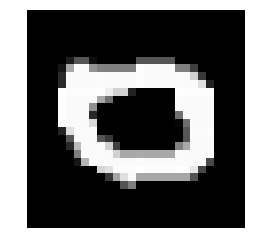

In [29]:
# Let us see what our data looks like! We read our image and display it.
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'images','train', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [30]:
# he above image is represented as numpy array, as seen below
img

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.

In [32]:
# For easier data manipulation, let’s store all our images as numpy arrays-----------------
temp= []
for img_name in train.filename:
    image_path = os.path.join(data_dir,'images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'images', 'test', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

In [33]:
# to test the proper functioning of our model we create a validation set. Let’s take a split size of 70:30 for train set vs 
# validation set
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

In [40]:
train_x.shape

(34300, 28, 28)

In [41]:
# Now we define some helper functions, which we use later on, in our programs
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch

def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

In [42]:
# Now comes the main part! Let us define our neural network architecture. We define a neural network with 3 layers;  
# input, hidden and output. The number of neurons in input and output are fixed, as the input is our 28 x 28 image and 
# the output is a 10 x 1 vector representing the class. We take 500 neurons in the hidden layer. This number can vary 
# according to need. We also assign values to remaining variables. 
### set all variables

# number of neurons in each layer--------------------------
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

# define placeholders--------------------------------------
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables----------------------------------
epochs = 5
batch_size = 128
learning_rate = 0.01

### define weights and biases of the neural network (refer this article if you don't understand the terminologies)

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [47]:
# Now create our neural networks computational graph------------------------
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

In [49]:
# Also, we need to define cost of our neural network
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer,labels= y))

In [50]:
# And set the optimizer, i.e. our backpropogation algorithm. Here we use Adam, which is an efficient variant of Gradient Descent 
# algorithm. There are a number of other optimizers available in tensorflow 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [51]:
# After defining our neural network architecture, let’s initialize all the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [53]:
# Now let us create a session, and run our neural network in the session. We also validate our models accuracy on validation set 
# that we created
with tf.Session() as sess:
    # create initialized variables
    sess.run(init)
    
    ### for each epoch, do:
    ###   for each batch, do:
    ###     create pre-processed batch
    ###     run optimizer by feeding batch
    ###     find cost and reiterate to minimize
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            
            avg_cost += c / total_batch
            
        print("Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost))
    
    print("\nTraining complete!")
    
    
    # find predictions on val set
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print("Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)}))
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

Epoch: 1 cost = 8.89807
Epoch: 2 cost = 1.82948
Epoch: 3 cost = 0.85988
Epoch: 4 cost = 0.55418
Epoch: 5 cost = 0.43006

Training complete!
Validation Accuracy: 0.95068


Prediction is:  9


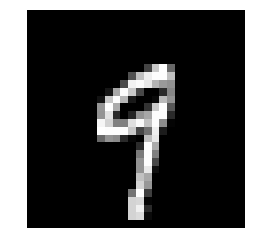

In [55]:
# To test our model with our own eyes, let’s visualize its predictions
img_name = rng.choice(test.filename)
filepath = os.path.join(data_dir, 'images', 'test', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - 49000

print("Prediction is: ", pred[test_index])

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [56]:
# Now let’s create a submission
sample_submission.filename = test.filename

sample_submission.label = pred

sample_submission.to_csv(os.path.join(data_dir, 'sub01.csv'), index=False)